# Training the Language-Based Type Estimator

## Boilerplate

* For code change detection
* Seeing log messages inside the notebook
* Checking TensorFlow configuration.
* Setting random seeds

In [44]:
%load_ext autoreload
%autoreload 2

SEED: int = 42

import logging
logger: logging.Logger = logging.getLogger()
logger.setLevel(logging.INFO)

import tensorflow as tf
tf.random.set_seed(SEED)

import numpy as np
np.random.seed(SEED)

logging.info(f"Tensorflow version {tf.__version__}")
logging.info(f"Devices available: {tf.config.list_physical_devices()}")

logging.info("Starting analysis...")

INFO:root:Tensorflow version 2.11.0
INFO:root:Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:root:Starting analysis...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration

Checking label counts on the training dataset

<AxesSubplot: xlabel='will_help', ylabel='count'>

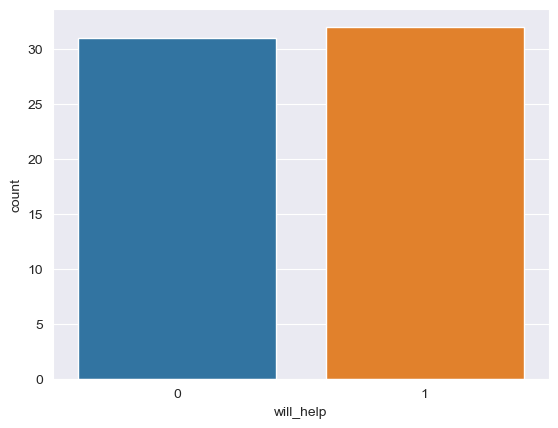

In [45]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

TRAINING_DATA_CSV_FILE = "data/training_data.csv"
training_dataset: pd.DataFrame = pd.read_csv(TRAINING_DATA_CSV_FILE)
validation_dataset: pd.DataFrame
training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.5)

sns.countplot(x="will_help", data=training_dataset)

## Sanity Checks

Let's train on a single sample, to verify data loading is working fine. We expect perfect accuracy after a few iterations.

In [46]:
from transformer_analyser import TransformerTypeAnalyser

type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser(epochs=5)
# type_analyser.train(training_dataset.head(1))

Instead of a single sample, we now train over a very small dataset. Again, we expect perfect accuracy after a few iterations.

In [47]:
small_sample: pd.DataFrame
_, small_sample = train_test_split(training_dataset, test_size=0.07, stratify=training_dataset["will_help"])

logging.info(small_sample["will_help"].value_counts())
type_analyser = TransformerTypeAnalyser(epochs=10)
# type_analyser.train(small_sample)


INFO:root:1    3
0    2
Name: will_help, dtype: int64


## Training the model
Training and validating with holdout data

In [48]:
type_analyser = TransformerTypeAnalyser(epochs=15, batch_size=8, learning_rate=3e-5)
# type_analyser.train(training_data=training_dataset, testing_data=validation_dataset)


## Calibrating Probabilities

First, let's evaluate probabilities right after training, over the validation dataset. We are using the Brier Score: smaller values are better.

In [49]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from typing import List

trained_type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser()
validation_text: List[str] = validation_dataset["text"].astype(str).tolist()
validation_probabilities: List[float] = trained_type_analyser.obtain_probabilities(validation_text, local=True)
validation_types: pd.Series = validation_dataset["will_help"].tolist()

brier_score: float = brier_score_loss(validation_types, validation_probabilities)
logging.info(f"Brier score after training: {brier_score}")



INFO:root:Loading model from ./model
Some layers from the model checkpoint at ./model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/home/cgc87/anaconda3/envs/tf/lib/python3.9/site-packages/

In [50]:
number_of_bins: int = 10
bin_true_probabilities, bin_predicted_probabilities = calibration_curve(validation_types, validation_probabilities,
                                                                       n_bins=number_of_bins)